# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
import os
from tqdm.notebook import tqdm
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [26]:
def imshow(img1, img2):
    
    img1 = TF.to_pil_image(img1, mode='L')
    img2 = TF.to_pil_image(img2, mode='L')
    
    plt.subplot(121)
    plt.imshow(img1)
    
    plt.subplot(122)
    plt.imshow(img2)
    
    plt.show()    
    
def show_plot(train_loss, val_loss):
    plt.figure(figsize=(15, 5))
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend()
    plt.grid()
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
class Config():
    training_dir = "./data_madori/train/"
    val_dir = './data_madori/val/'
    testing_dir = "./data_madori/test/"
    checkpoint_dir = './checkpoint'
    batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class MadoriDataset(Dataset):
    def __init__(self, data_dir, img_size=(256, 256)):
        self.img_paths = [os.path.join(data_dir, x) for x in os.listdir(data_dir)]
        self.img_size = (256, 256)
        
    def __len__(self):
        return len(self.img_paths)
    
    def _resize(self, img):
        w, h = img.size
        if w < h:
            a = 256.0 / h
            b = int(w * a)
            img = img.resize((b, 256), Image.BILINEAR)
        else:
            a = 256.0 / w
            b = int(h * a)
            img = img.resize((256, b), Image.BILINEAR)
        return img
    
    def _pad(self, img):
        w, h = img.size
        img = TF.pad(img, (0,0,256-w,0), padding_mode='edge') if h == 256 else \
               TF.pad(img, (0,0,0,256-h), padding_mode='edge')
        
        if img.size != self.img_size:
            print('|-'*20, img.size, (w, h)) # (97, 256) (97, 249)
        return img
    
    def _transform(self, img):
        return self._pad(self._resize(img))
    
    def _aug_img(self, image):
        if random.random() > 0.5:
            image = TF.rotate(image, random.choice([90, 180, 270]))
        if random.random() > 0.5:
            image = TF.hflip(image)
        if random.random() > 0.5:
            image = TF.vflip(image)
        return image
    
    def __getitem__(self, idx):
        img_path1 = self.img_paths[idx]
        img1 = self._transform(Image.open(img_path1).convert('L'))
        label = random.randint(0, 1)
        if label:
            # choose different floorplan
            img_path2 = img_path1
            while img_path2 == img_path1:
                img_path2 = random.choice(self.img_paths)
            img2 = self._transform(Image.open(img_path2).convert('L'))
        else:
            # choose similar floorplan by augmentation
            img2 = self._aug_img(img1)
        img1, img2 = TF.to_tensor(img1), TF.to_tensor(img2)
        return img1, img2, torch.from_numpy(np.array([label],dtype=np.float32))

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

torch.Size([64, 1, 256, 256]) torch.Size([64, 1, 256, 256])
tensor([0.])


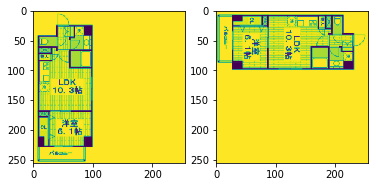

tensor([0.])


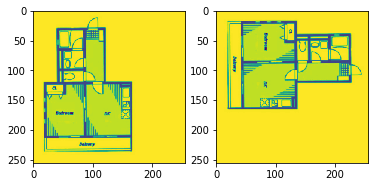

tensor([1.])


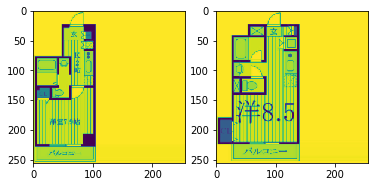

In [5]:
dset_loader = DataLoader(MadoriDataset(Config.training_dir), 
                           batch_size=Config.batch_size, 
                           shuffle=True)

for i, batch in enumerate(dset_loader):
    img1, img2, label = batch
    print(img1.size(), img2.size())
    for k in range(3):
        print(label[k])
        imshow(img1[k], img2[k])
    break

## Neural Net Definition
We will use a standard convolutional neural network

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*256*256, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [7]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - 
                                        euclidean_distance, min=0.0), 2))
        return loss_contrastive

## Training Time!

In [8]:
train_dataloader = DataLoader(MadoriDataset(Config.training_dir), 
                                shuffle=True,
                                batch_size=Config.batch_size)

val_dataloader = DataLoader(MadoriDataset(Config.val_dir), 
                                shuffle=False,
                                batch_size=Config.batch_size)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [11]:
train_loss_history, val_loss_history = [], []
lowest_epoch_train_loss = lowest_epoch_val_loss = float('inf')

In [12]:
for epoch in tqdm(range(Config.train_number_epochs)):
    # training
    net.train()
    epoch_train_loss = 0
    for batch_no, data in enumerate(train_dataloader):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        batch_train_loss = criterion(output1,output2,label)
        epoch_train_loss += batch_train_loss.item()
        batch_train_loss.backward()
        optimizer.step()
    epoch_train_loss /= (batch_no + 1)
    if epoch_train_loss < lowest_epoch_train_loss:
        lowest_epoch_train_loss = epoch_train_loss
        torch.save(net.state_dict(), f'{Config.checkpoint_dir}/best_train.pth')
    train_loss_history.append(epoch_train_loss)
    
    # validation
    net.eval()
    with torch.no_grad():
        epoch_val_loss = 0
        for batch_no, data in enumerate(val_dataloader):
            img0, img1, label = data
            img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
            output1,output2 = net(img0,img1)
            batch_val_loss = criterion(output1,output2,label)
            epoch_val_loss += batch_val_loss
        epoch_val_loss /= (batch_no + 1)
        if epoch_val_loss < lowest_epoch_val_loss:
            lowest_epoch_val_loss = epoch_val_loss
            torch.save(net.state_dict(), f'{Config.checkpoint_dir}/best_val.pth')
        val_loss_history.append(epoch_val_loss)
    print(f'Epoch {epoch} training loss is {epoch_train_loss}, validation loss is {epoch_val_loss}')

Epoch 0 training loss is 59.47874711619483, validation loss is 1.8648229837417603
Epoch 1 training loss is 33.62953553376374, validation loss is 138.57778930664062
Epoch 2 training loss is 29.101379977332222, validation loss is 8.338308334350586
Epoch 3 training loss is 15.932166355627555, validation loss is 5.2618842124938965
Epoch 4 training loss is 9.102350936995613, validation loss is 14.613302230834961
Epoch 5 training loss is 4.889839733088458, validation loss is 5.784441947937012
Epoch 6 training loss is 3.2826692263285318, validation loss is 0.8609918355941772
Epoch 7 training loss is 2.7855146394835577, validation loss is 2.355966091156006
Epoch 8 training loss is 3.172046049877449, validation loss is 1.1428899765014648
Epoch 9 training loss is 2.33062227346279, validation loss is 0.6752687692642212
Epoch 10 training loss is 2.3947188677611173, validation loss is 1.7531455755233765
Epoch 11 training loss is 1.8560596307118733, validation loss is 8.80968189239502
Epoch 12 train

Epoch 97 training loss is 0.06145108394600727, validation loss is 0.07744136452674866
Epoch 98 training loss is 0.05793768802174815, validation loss is 0.06515295058488846
Epoch 99 training loss is 0.0636475495994091, validation loss is 0.05162316560745239



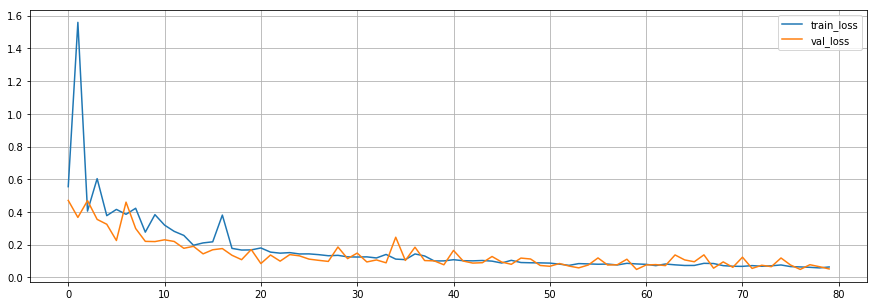

In [28]:
show_plot(train_loss_history[20:], val_loss_history[20:])

## Some simple testing

In [23]:
epoch_test = 0
net = SiameseNetwork().to(device)
net.load_state_dict(torch.load(f'{Config.checkpoint_dir}/best_val.pth'))
test_dataloader = DataLoader(MadoriDataset(Config.testing_dir), 
                                shuffle=False,
                                batch_size=1)

label: 0.0, pred: 0.0038022242952138186


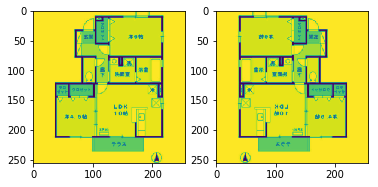

label: 1.0, pred: 0.0


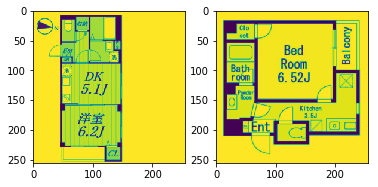

label: 0.0, pred: 0.03675319626927376


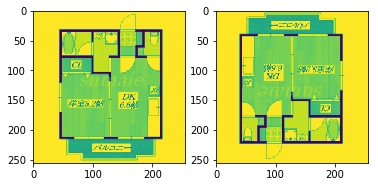

label: 1.0, pred: 0.0


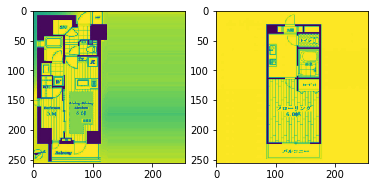

label: 1.0, pred: 0.033012982457876205


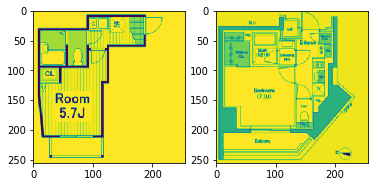

label: 1.0, pred: 0.0


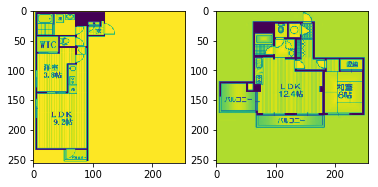

label: 1.0, pred: 0.0


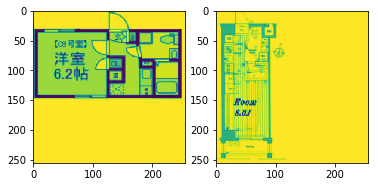

label: 1.0, pred: 0.0


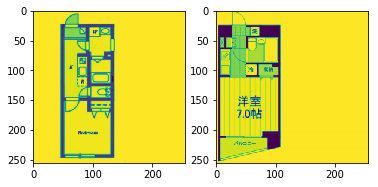

label: 1.0, pred: 0.0


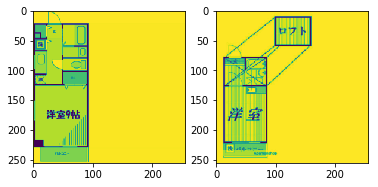

label: 0.0, pred: 0.034379053860902786


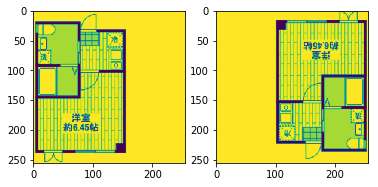

label: 1.0, pred: 0.0


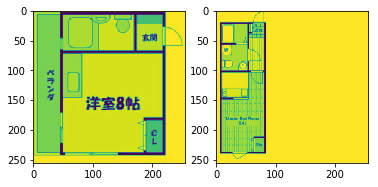

In [29]:
net.eval()
with torch.no_grad():
    for batch_no, data in enumerate(test_dataloader):
        if batch_no > 10:
            break
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
        output1,output2 = net(img0,img1)
        batch_test_loss = criterion(output1,output2,label)
        
        img0, img1 = img0.cpu(), img1.cpu()
        print(f'label: {label.item()}, pred: {batch_test_loss.item()}')
        imshow(img0[0], img1[0])